In [5]:
%matplotlib inline

import time
import pickle
import numpy as np
from scipy import interpolate
import scipy.integrate as integrate
from scipy.misc import derivative



import MF_functions as mff

import matplotlib.pyplot as plt

π = np.pi

In [ ]:
mff.U = 8
mff.beta = 1./0.04

mu_min, mu_max, mu_number = -8,16, 100
mu_r = np.linspace(mu_min, mu_max, mu_number)

F = np.zeros(mu_number)
n = np.zeros(mu_number)
m = np.zeros(mu_number)
mu_res = np.zeros(mu_number)

 
mff.Qx, mff.Qy, mff.Qz = π,π,π

for mu_idx, mu in enumerate(mu_r):
    n[mu_idx], m[mu_idx], mu_res[mu_idx] = mff.solve_fixed_mu(mu)
    F[mu_idx] = mff.compute_free_energy("Gibbs", n[mu_idx], m[mu_idx], mu)

In [ ]:
plt.figure(figsize=[10,5])
plt.subplot(121)

plt.plot(mu_r[1:-1], -(F[2:] - F[:-2])/(mu_r[2]-mu_r[0]), '-', label=r"$-\frac{\partial G}{\partial\mu}$")
plt.plot(mu_r, n, '-', label="n")
plt.plot(mu_r, m, '-', label="m")

plt.plot([mu_r[0], mu_r[-1]], [1,1], "k--", linewidth=0.75)

plt.xlabel("mu")
plt.rc('legend', fontsize=14)
plt.legend()

plt.subplot(122)

plt.plot(mu_r, F, '-', label="G")
plt.xlabel("mu")
plt.legend()

plt.show()

# Free energy difference at fixed T

With some integrals, partial derivatives, reminding that $F-G = \mu n$ and that $\frac{\partial G}{\partial \mu} = -n$ we get:

$$F_Q(n,T) - F_{(\pi,\pi)}(n_0,T) = \Delta F_Q(n,T) + \int_{\mu(n_0)}^{\mu(n)} \mu^\prime\frac{\partial n_{(\pi,\pi)}}{\partial\mu}(\mu^\prime,T) \,d\mu^\prime $$

But maybe we can use a simpler expression which is:
$$F_Q(n,T) - F_{(\pi,\pi)}(n_0,T) = \Delta F_Q(n,T) + \int_{n_0}^n \mu(n^\prime,T) \,d\mu^\prime $$


$\Delta F_Q(n,T) = F_Q(n,T) - F_{(\pi,\pi)}(n,T)$ can be computed for Mean-Field and DMFT results, the integral is  obtained from the numerical computation of $n(\mu)$, and $F_{(\pi,\pi)}(n_0,T)$ will be a constant offset. It follows that we can compare the Helmholtz energy of any $Q$ point to the energy of the antiferromagnetic order $Q = (\pi,\pi)$ at half-filling by setting $n_0 = 1$.


## Benchmark in MF
Here the method is tested for Mean-Field, where energies are known absolutely from the start.
The integral term can be part integrated into:
$$ \int_{\mu(n_0)}^{\mu(n)} \mu^\prime\frac{\partial n_{(\pi,\pi)}}{\partial\mu}(\mu^\prime,T) \,d\mu^\prime = n\mu(n) - n_0\mu(n_0) - \int_{\mu(n_0)}^{\mu(n)} n_{(\pi,\pi)}(\mu^\prime,T) \,d\mu^\prime$$
The $ n_0\mu(n_0) $ term will be added to the constant offset.

In [3]:
def int_diff(U,n,T):
    """Return F_ππ(n,T) - F_ππ(1.0,T)"""
    
    mff.U = 8
    mff.Qx, mff.Qy, mff.Qz = π,π,π
    mff.beta = 1/T
    
    _,_, µ_n = mff.solve_mean_field(n)
    _,_, µ_n0 = mff.solve_mean_field(1.0)
        
    f = lambda µ: µ * lambda x : mff.solve_fixed_mu(µ)[0]
    return integrate.quad(f, µ_n0, µ_n)

SyntaxError: invalid syntax (<ipython-input-3-0d3c0411139a>, line 11)

In [8]:
mff.U = 8
mff.Qx, mff.Qy, mff.Qz = π,π,π
T = 0.4
mff.beta = 1/T

n_number = 15
n_r = np.linspace(1.0,0.4,n_number)
I_new = np.zeros(n_number)
error = np.zeros(n_number)
I_MF = np.zeros(n_number)


_,_, µ_n0 = mff.solve_mean_field(1.0)


for i, n in enumerate(n_r):
    print(f"Integrating n = {n:1.2f}")
    #_,_, µ_n = mff.solve_mean_field(n)
    
    #f = lambda µ: mff.solve_fixed_mu(µ)[0]

    #I, error[i] = integrate.quad(f, µ_n0, µ_n)
    #I_new[i] = n*µ_n - 1.0*µ_n0 - I
    
    f = lambda n : mff.solve_mean_field(n)[2]
    
    I_new[i], error[i] = integrate.quad(f, 1.0, n)
    
    
    I_MF[i] = mff.compute_free_energy("Helmholtz",* mff.solve_mean_field(n))
    
I_MF -= mff.compute_free_energy("Helmholtz",* mff.solve_mean_field(1.0))

Integrating n = 1.00
Integrating n = 0.96


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=[10,6])

plt.errorbar(n_r, I_new, yerr=error, fmt='-+', label="new")
plt.plot(n_r, I_MF, "-+", label="exact")

plt.plot([0.4,1.0],[0,0], "--k", linewidth=0.5)

plt.xlabel("n")
plt.ylabel(r"$F_{(\pi,\pi)}(n,T) - F_{(\pi,\pi)}(1.0,T)$")
plt.legend()

plt.show()

## Benchmarking second method

In [22]:
mff.U = 8
mff.Qx, mff.Qy, mff.Qz = π,π,π
T = 0.4
mff.beta = 1/T

n_number = 15
n_r = np.linspace(1.0,0.4,n_number)

Γ = np.zeros(n_number)
µ = np.zeros(n_number)

for i,n in enumerate(n_r):
    if i % 2:
        print(f"Integrating n = {n:1.2f}")
    n_res, m_res, µ[i] = mff.solve_mean_field(n)
    Γ[i] = mff.compute_free_energy("Helmholtz", n_res, m_res, µ[i])

Integrating n = 0.96
Integrating n = 0.87
Integrating n = 0.79
Integrating n = 0.70
Integrating n = 0.61
Integrating n = 0.53
Integrating n = 0.44


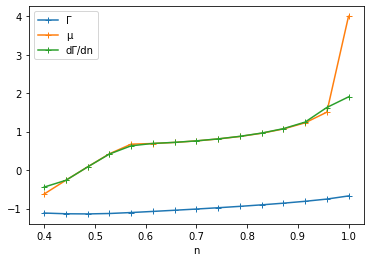

In [24]:
plt.plot(n_r, Γ, "-+", label="Γ")
plt.plot(n_r, µ, "-+", label="µ")

dΓ = np.zeros(n_number)
dΓ[1:-1] = (Γ[2:] - Γ[:-2])/(n_r[2:] - n_r[:-2])
dΓ[0] = (Γ[1] - Γ[0])/(n_r[1] - n_r[0])
dΓ[-1] = (Γ[-1] - Γ[-2])/(n_r[-1] - n_r[-2])

plt.plot(n_r, dΓ, "-+", label="dΓ/dn")

plt.xlabel("n")

plt.legend()
plt.show()

## Symbolic diagonalization of the mean-field Hamiltonian

In [1]:
import sympy as sp

# ---- Parameters ---- #
a = sp.Symbol('a')
b = sp.Symbol('b')
g = sp.Symbol('g')


# ---- Block of Hamiltonian ---- #
H_k = sp.Matrix([[a-b, 1j*g],  \
                 [-1j*g, a+b]])
(P_0, H_k_diag) = H_k.diagonalize()

In [2]:
H_k

Matrix([
[   a - b, 1.0*I*g],
[-1.0*I*g,   a + b]])

In [3]:
H_k_diag

Matrix([
[a - (b**2 + g**2)**0.5,                      0],
[                     0, a + (b**2 + g**2)**0.5]])

In [14]:
P_0

Matrix([
[I*g/(b - (b**2 + g**2)**0.5), I*g/(b + (b**2 + g**2)**0.5)],
[                         1.0,                          1.0]])

In [15]:
P_0.inv()

Matrix([
[-1.0*(b**2 + g**2)**(-0.5)*(0.5*I*b**2 - 0.5*I*(b**2 + g**2)**1.0)/g, -1.0*(0.5*b**4 - 1.0*b**3*(b**2 + g**2)**0.5 + 1.0*b*(b**2 + g**2)**1.5 - 0.5*(b**2 + g**2)**2.0)/(1.0*b**3*(b**2 + g**2)**0.5 - 1.0*b**2*(b**2 + g**2)**1.0 - 1.0*b*(b**2 + g**2)**1.5 + 1.0*(b**2 + g**2)**2.0)],
[ 1.0*(b**2 + g**2)**(-0.5)*(0.5*I*b**2 - 0.5*I*(b**2 + g**2)**1.0)/g,                                                                                                                       1.0*(0.5*b**2 - 0.5*(b**2 + g**2)**1.0)/(1.0*b*(b**2 + g**2)**0.5 - 1.0*(b**2 + g**2)**1.0)]])

In [5]:
sp.simplify(-1j*g*(b-sp.sqrt(b*b+g*g))/(g*g + (b-sp.sqrt(b*b+g*g))**2))

-1.0*I*g*(b - sqrt(b**2 + g**2))/(g**2 + (b - sqrt(b**2 + g**2))**2)

In [6]:
sp.simplify( (b-sp.sqrt(b*b+g*g))**2 / (g**2 + (b-sp.sqrt(b*b+g*g))**2) )

(b - sqrt(b**2 + g**2))**2/(g**2 + (b - sqrt(b**2 + g**2))**2)

In [7]:
x1 = -1j*g*(b-sp.sqrt(b*b+g*g))/(g*g + (b-sp.sqrt(b*b+g*g))**2)
x2 = (b-sp.sqrt(b*b+g*g))**2 / (g**2 + (b-sp.sqrt(b*b+g*g))**2)
sp.simplify(x1*(-x1) + x2**2)

(b - sqrt(b**2 + g**2))**2*(1.0*g**2 + (b - sqrt(b**2 + g**2))**2)/(g**2 + (b - sqrt(b**2 + g**2))**2)**2

## Numerical verification of the free energy formula

In [186]:
mff.U = 8
mff.Qx, mff.Qy, mff.Qz = π,π,π
T = 0.6
mff.beta = 1/T

q_res = 21
qr = np.linspace(0,1,q_res)

Γ = np.zeros(q_res)
Ω = np.zeros(q_res)
dΓ = np.zeros((q_res,3))

#ΓR
for i,q in enumerate(qr):
    
    print(f"Computing q/π = {q:1.2f}")
    
    mff.Qx, mff.Qy, mff.Qz = *[π*q], π,π
    
    n,m,µ = mff.solve_mean_field(0.7)
    
    Γ[i] = mff.compute_free_energy("Helmholtz", n,m,µ)
    Ω[i] = mff.compute_free_energy("Gibbs", n,m,µ)
    dΓ[i,:] = mff.compute_grad_free_energy('Helmholtz', n,m,µ)

Computing q/π = 0.00
Computing q/π = 0.05
Computing q/π = 0.10
Computing q/π = 0.15
Computing q/π = 0.20
Computing q/π = 0.25
Computing q/π = 0.30
Computing q/π = 0.35
Computing q/π = 0.40
Computing q/π = 0.45
Computing q/π = 0.50
Computing q/π = 0.55
Computing q/π = 0.60
Computing q/π = 0.65
Computing q/π = 0.70
Computing q/π = 0.75
Computing q/π = 0.80
Computing q/π = 0.85
Computing q/π = 0.90
Computing q/π = 0.95
Computing q/π = 1.00


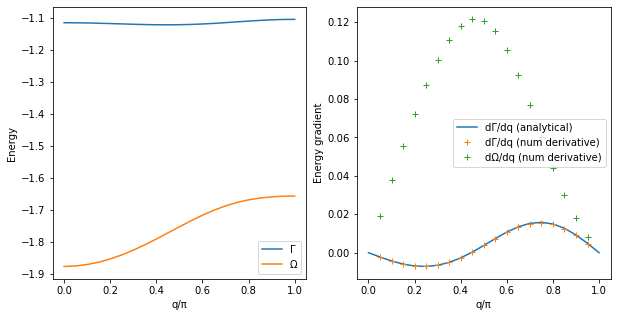

In [195]:
plt.figure(figsize=[10,5])

plt.subplot(121)
plt.plot(qr, Γ , label = "Γ")
plt.plot(qr, Ω , label = "Ω" )

plt.xlabel("q/π")
plt.ylabel("Energy")
plt.legend()

plt.subplot(122)

plt.plot(qr, np.dot(dΓ, [1,1,1]), label = "dΓ/dq (analytical)")
dΓ_num = (Γ[2:] - Γ[:-2])/(π*(qr[2:] - qr[:-2]))
plt.plot(qr[1:-1], dΓ_num, "+", label = "dΓ/dq (num derivative)")
dΩ_num = (Ω[2:] - Ω[:-2])/(π*(qr[2:] - qr[:-2]))
plt.plot(qr[1:-1], dΩ_num, "+", label = "dΩ/dq (num derivative)")

plt.xlabel("q/π")
plt.ylabel("Energy gradient")
plt.legend()


plt.show()

In [25]:
import os
os.getcwd()

'/Users/LiamRampon/Downloads'